In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [2]:
train_path = "masked_data/training"
validation_path = "original_data/validation"
test_path = "original_data/test"

In [3]:
dimentions = (299, 299)
batch_size = 64

n_class = 2

In [4]:
train_datagen  = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [5]:
valid_datagen  = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_path, 
    target_size=dimentions,
    batch_size=batch_size
)

Found 710 images belonging to 2 classes.


In [7]:
validation_generator = valid_datagen.flow_from_directory(
    validation_path, 
    target_size=dimentions,
    batch_size=batch_size
)

Found 239 images belonging to 2 classes.


In [8]:
test_generator = valid_datagen.flow_from_directory(
    test_path, 
    target_size=dimentions,
    batch_size=batch_size
)

Found 239 images belonging to 2 classes.


In [9]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from keras.models import Model

base_model = InceptionV3(
    weights='imagenet', 
    include_top=False,
)

x = base_model.output 
x = GlobalAveragePooling2D()(x) 
x = Dense(1024, activation='relu')(x) 
predictions = Dense(n_class, activation='softmax')(x)    
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
from keras import metrics

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [11]:
from keras.callbacks import ModelCheckpoint  

# !mkdir saved_models

model_file = 'saved_models/baseline_weights.best.InceptionV3.hdf5'
checkpointer = ModelCheckpoint(filepath=model_file, 
                               verbose=1, save_best_only=True)

In [12]:
epochs = 10

In [13]:
train_history = model.fit_generator(train_generator, 
                                    validation_data=validation_generator, 
                                    epochs=epochs, 
                                    callbacks=[checkpointer],
                                    steps_per_epoch=train_generator.samples // batch_size, 
                                    validation_steps=validation_generator.samples // batch_size
                                   )

Epoch 1/10
11/11 [==============================] - 53s 5s/step - loss: 0.2934 - acc: 0.9006 - val_loss: 2.5043 - val_acc: 0.7604

Epoch 00001: val_loss improved from inf to 2.50426, saving model to saved_models/baseline_weights.best.InceptionV3.hdf5
Epoch 2/10
11/11 [==============================] - 26s 2s/step - loss: 0.1882 - acc: 0.9327 - val_loss: 1.2097 - val_acc: 0.5314

Epoch 00002: val_loss improved from 2.50426 to 1.20972, saving model to saved_models/baseline_weights.best.InceptionV3.hdf5
Epoch 3/10
11/11 [==============================] - 23s 2s/step - loss: 0.1451 - acc: 0.9385 - val_loss: 1.8606 - val_acc: 0.7257

Epoch 00003: val_loss did not improve from 1.20972
Epoch 4/10
11/11 [==============================] - 23s 2s/step - loss: 0.0852 - acc: 0.9628 - val_loss: 7.7243 - val_acc: 0.4171

Epoch 00004: val_loss did not improve from 1.20972
Epoch 5/10
11/11 [==============================] - 23s 2s/step - loss: 0.3465 - acc: 0.9233 - val_loss: 1.1610 - val_acc: 0.4583


In [14]:
train_history.history

{'val_loss': [2.5042593479156494,
  1.2097189705712454,
  1.860616807937622,
  7.724317643301828,
  1.1610410610834758,
  0.9003484473909651,
  2.6238109724862233,
  2.284533660071237,
  2.2618903716405234,
  2.7631020995548794],
 'val_acc': [0.7604166666666666,
  0.5314285697255816,
  0.7257142778805324,
  0.4171428581646511,
  0.4583333333333333,
  0.7314285635948181,
  0.8114285782405308,
  0.811428576878139,
  0.7708333333333334,
  0.8285714340209961],
 'loss': [0.2934055653485385,
  0.20034441774013242,
  0.15503544941682934,
  0.08549673387048415,
  0.19519400079922042,
  0.14486024917417636,
  0.1413070374967144,
  0.14525135659580998,
  0.11305007965941179,
  0.15040943953828545],
 'acc': [0.9005681818181818,
  0.9272445820433437,
  0.93343653250774,
  0.9597523219814241,
  0.944272446004968,
  0.9520123839009288,
  0.945820433621067,
  0.9396284827876017,
  0.9551083589485925,
  0.9411764704037008]}

In [15]:
import matplotlib.pyplot as plt

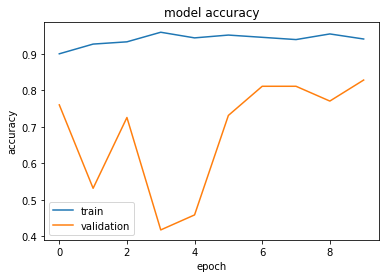

In [16]:
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

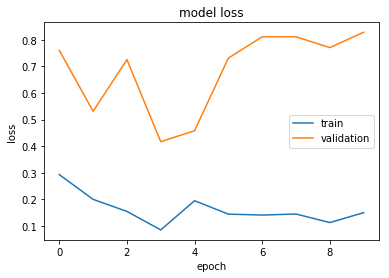

In [17]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [18]:
tesr_result = model.evaluate_generator(test_generator, steps=10)

In [19]:
tesr_result

[2.7661417907614125, 0.8283828424148434]

In [20]:
predict = model.predict_generator(test_generator,steps = 10)

In [21]:
import cv2
import numpy as np


from keras.preprocessing import image
# img = cv2.imread(path_to_one_file)
# img = np.array([img]).reshape((1, 3, 299, 299))

def to_tensor(img_path): 
    img = image.load_img(img_path, target_size=(299, 299))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255. 
    
    return img_tensor

In [22]:
def make_predict(img_path): 
    class_dic = {}
    for k, v in test_generator.class_indices.items():
        class_dic[v] = k
    
    
    y_prob = model.predict(to_tensor(img_path))
    y_classes = y_prob.argmax(axis=-1)
    return class_dic[y_classes[0]]

In [23]:
img_path = "original_data/test/benign/ISIC_0004472.jpg"
make_predict(img_path)

'benign'

In [24]:
class_dic = dict(test_generator.class_indices)
print(class_dic)

one_hot = {}
for k, v in test_generator.class_indices.items():
    one_hot[v] = k
print(one_hot)

{'benign': 0, 'malignant': 1}
{0: 'benign', 1: 'malignant'}


In [25]:
from os import listdir 

y_true = [] 
y_pred = []

class_name = "benign"
for img in listdir("original_data/test/{}/".format(class_name)):
    img_path = "original_data/test/{}/{}".format(class_name, img)
    pred = make_predict(img_path)
    
    y_true.append(class_name)
    y_pred.append(pred)
    
class_name = "malignant"
for img in listdir("original_data/test/{}/".format(class_name)):
    img_path = "original_data/test/{}/{}".format(class_name, img)
    pred = make_predict(img_path)
    
    y_true.append(class_name)
    y_pred.append(pred)
    

In [26]:
len(y_true) == len(y_pred)

True

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=["benign", "malignant"])

In [28]:
import pandas as pd
df_cm = pd.DataFrame(cm, ["benign", "malignant"], ["benign", "malignant"])

In [29]:
import seaborn as sn

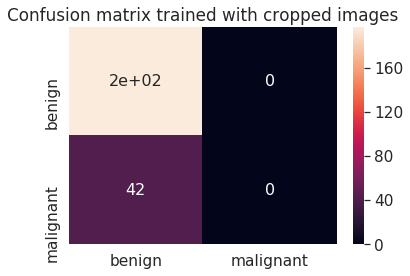

In [30]:
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}).set_title("Confusion matrix trained with cropped images")# font size
plt.show()

In [31]:
from sklearn.metrics import f1_score
y_true_01 = [class_dic[p] for p in y_true]
y_pred_01 = [class_dic[p] for p in y_pred]
f1_score(y_true_01, y_pred_01)

/home/tetsumichi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [32]:
from sklearn.metrics import recall_score
recall_score(y_true_01, y_pred_01) 

0.0

In [33]:
from sklearn.metrics import precision_score
precision_score(y_true_01, y_pred_01) 

/home/tetsumichi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [36]:
# y_pred_01